In [20]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# Check that TensorFlow can see the GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Prepare the audio files
Run the short time Fourier transform over the audio files and save as numpy arrays

In [89]:
def convert_audio_to_complex_array(filename, outfilename=None, overwrite=False):
    """convert_audio_to_complex_array -- using librosa's short time Fourier transform.
    
    Arguments:
    filename -- filepath to the file that you to copy to an array
    outfilename -- filepath to the output array 
    overwrite -- whether to overwrite if a file already exists with the given outfilename
    
    Returns -- None
    """
    
    audio_data, sr = librosa.load(filename)
    
    # Get the CQT magnitude, 7 ocatves at 36 bins per octave
    # NOTE THERE IS A MIN FREQ SETTING fmin=librosa.note_to_hz('C2'),
    
    C = np.abs(librosa.cqt(y=audio_data, sr=sr, bins_per_octave=36, n_bins=7*36))
    
    np.save(filename[:-4] + ".npy", C)

In [90]:
# Convert all the files to numpy arrays and save
total = len(os.listdir("samples/"))

for i, item in enumerate(os.listdir("samples/")):
    convert_audio_to_complex_array("samples/"+item)
    print(f"{i+1} out of {total}")

C:\Users\Tyler\AppData\Local\Temp\ipykernel_13268\3991768649.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(filename)


NoBackendError: 

In [91]:
# Delete the mp3 files
for i, item in enumerate(os.listdir("samples/")):
    if item.endswith(".mp3"):
        os.remove("samples/" + item)

# Load all the files into a single tensor

In [92]:
lengths = []

for i, item in enumerate(os.listdir("samples/")):
    S = np.load("samples/" + item)
    lengths.append(np.shape(S)[1])

C:\Users\Tyler\AppData\Local\Temp\ipykernel_13268\498940116.py:4: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  img = librosa.display.specshow(librosa.amplitude_to_db(sample), x_axis='time', y_axis='cqt_note', ax=ax)


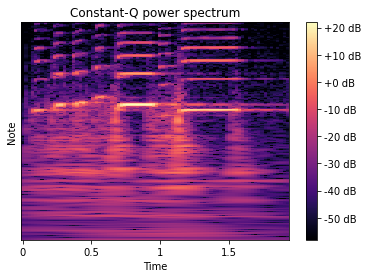

In [131]:
sample = np.load("samples/" + os.listdir("samples/")[0])

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(sample), x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

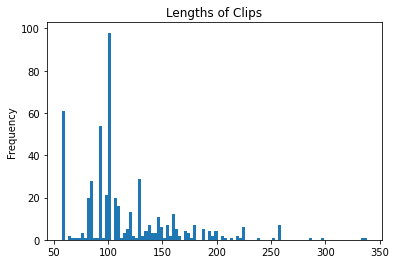

In [93]:
# Plot Histogram on x
plt.hist(lengths, bins=100)
plt.gca().set(title='Lengths of Clips', ylabel='Frequency');

In [94]:
print(type(np.load("samples/" + os.listdir("samples/")[0])[0][0]))

<class 'numpy.float32'>


In [155]:
#Create the mega tensor

target_len = 144
target_height = 256
target_samples = len(os.listdir("samples/"))

mega_tensor = np.zeros([target_samples, target_height, target_len, 1], dtype = np.float32)

# Add every sample to the mega tensor
for i, name in enumerate(os.listdir("samples/")):
    item = np.load("samples/" + name)
    
    for j in range(len(item)):
        for k in range(len(item[0])):
            if k < target_len:
                mega_tensor[i][j][k] = item[j][k]
                
                
# Then save the mega tensor
np.save("data.npy", mega_tensor)

# Define the model

In [178]:
## KERAS MODELS
latent_dim = 256

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 18 * 256),
        layers.Reshape((32, 18, 256)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 147456)            37896192  
                                                                 
 reshape_18 (Reshape)        (None, 32, 18, 256)       0         
                                                                 
 conv2d_transpose_54 (Conv2D  (None, 64, 36, 256)      1048832   
 Transpose)                                                      
                                                                 
 leaky_re_lu_96 (LeakyReLU)  (None, 64, 36, 256)       0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 128, 72, 512)     2097664   
 Transpose)                                                      
                                                                 
 leaky_re_lu_97 (LeakyReLU)  (None, 128, 72, 512)      0 

In [179]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 144, 1)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 72, 128)      2176      
                                                                 
 leaky_re_lu_99 (LeakyReLU)  (None, 128, 72, 128)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 36, 256)       524544    
                                                                 
 leaky_re_lu_100 (LeakyReLU)  (None, 64, 36, 256)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 18, 256)       1048832   
                                                                 
 leaky_re_lu_101 (LeakyReLU)  (None, 32, 18, 256)      0         
                                                                 
 flatten_14 (Flatten)        (None, 147456)          

# Create the Dataset

In [170]:
# Load dataset from directory with keras
mega_tensor =  np.load("data.npy")

train_ds = tf.data.Dataset.from_tensor_slices(mega_tensor)
dataset = train_ds.batch(1)


# Training
https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391

1. Select a number of real images from the training set.
2. Generate a number of fake images. This is done by sampling random noise vectors and creating images from them using the generator
3. Train the discriminator for one or more epochs using both fake and real images. This will update on the discrimators weights by labeling all the real images as 1 and the fake images as 0.
4. Generate another number of fake images
5. Train the full GAN model for one or more epochs using only fake images. This will update only the generator's weights by labeling all fake images as 1. 

**SOURCE**: Link above

In [174]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [180]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=256):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            
            sample = np.reshape(generated_images[i], (256, 144))
            
            # Save the numpy array
            np.save(f"output-arrays/epoch_{epoch+1}_sample_{i}.npy", sample)
            
            # Save a spectrogram
            fig, ax = plt.subplots()
            img = librosa.display.specshow(librosa.amplitude_to_db(sample), x_axis='time', y_axis='cqt_note', ax=ax)
            ax.set_title('Constant-Q power spectrum')
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
            plt.savefig(f"output-specs/epoch_{epoch+1}_sample_{i}.png")
            plt.close()


In [181]:
epochs = 500   # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=2, latent_dim=256)]
)

Epoch 1/500
505/505 [==============================] - 153s 301ms/step - d_loss: 0.5117 - g_loss: 1.8499


C:\Users\Tyler\AppData\Local\Temp\ipykernel_13268\4032071171.py:20: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  img = librosa.display.specshow(librosa.amplitude_to_db(sample), x_axis='time', y_axis='cqt_note', ax=ax)


Epoch 2/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.1702 - g_loss: 3.7062
Epoch 3/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.3582 - g_loss: 3.2122
Epoch 4/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.5046 - g_loss: 1.4064
Epoch 5/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.5010 - g_loss: 1.3564
Epoch 6/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.4736 - g_loss: 1.4924
Epoch 7/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.4679 - g_loss: 1.4710
Epoch 8/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.4938 - g_loss: 1.7428
Epoch 9/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.4306 - g_loss: 1.5738
Epoch 10/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.4721 - g_loss: 1.4331
Epoch 11/500
505/505 [==============================] 

505/505 [==============================] - 147s 291ms/step - d_loss: 0.2564 - g_loss: 2.4898
Epoch 80/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2531 - g_loss: 2.5713
Epoch 81/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2493 - g_loss: 2.5775
Epoch 82/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2898 - g_loss: 2.4491
Epoch 83/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2328 - g_loss: 2.5610
Epoch 84/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2384 - g_loss: 2.5816
Epoch 85/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2461 - g_loss: 2.5307
Epoch 86/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2741 - g_loss: 2.6972
Epoch 87/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2487 - g_loss: 2.6960
Epoch 88/500
505/505 [==============================] - 147

505/505 [==============================] - 147s 291ms/step - d_loss: 0.1847 - g_loss: 3.5066
Epoch 156/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1760 - g_loss: 3.4903
Epoch 157/500
505/505 [==============================] - 148s 293ms/step - d_loss: 0.1898 - g_loss: 3.5153
Epoch 158/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1643 - g_loss: 3.5197
Epoch 159/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1431 - g_loss: 4.0519
Epoch 160/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1646 - g_loss: 3.5399
Epoch 161/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.2175 - g_loss: 3.3245
Epoch 162/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1575 - g_loss: 3.5753
Epoch 163/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1889 - g_loss: 3.6653
Epoch 164/500
505/505 [============================

505/505 [==============================] - 147s 291ms/step - d_loss: 0.1737 - g_loss: 4.2792
Epoch 232/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1437 - g_loss: 4.1633
Epoch 233/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1294 - g_loss: 4.4564
Epoch 234/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1723 - g_loss: 4.5406
Epoch 235/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1821 - g_loss: 4.2322
Epoch 236/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1664 - g_loss: 4.2716
Epoch 237/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1437 - g_loss: 4.1737
Epoch 238/500
505/505 [==============================] - 147s 291ms/step - d_loss: 0.1387 - g_loss: 4.6811
Epoch 239/500
505/505 [==============================] - 148s 294ms/step - d_loss: 0.1090 - g_loss: 4.2495
Epoch 240/500
505/505 [============================

KeyboardInterrupt: 